__Author: Martin Ng__    
__Date: 10/01/20__

Purpose of this notebook is to contruct the Point of Loan Application (POA) dataset that will be the base dataset where the modelling is carried out on.

# POA Data Construction

For data construction, we will use the earlier code to properly load the dataset, followed by using the lists of features indentified earlier.

Following that, we will be proceeding to do a further round of data subsetting, feature selection and target label construction from the dataset to mimic the POA data, given a number of constraints:

1. Applicants should belong to the thin-file, no-file group, i.e. clients who have no or less than 6 months of credit records with the financial institute

2. The dataset should be labelled, indicating if the applicants defaults anytime after their initial application. The definition of default adopted would be the initial failure to make payments for more than 60 days within 6 months from the loan disbursement.

3. For loans which have defaulted within the timeframe but later changed its status (to either repaid, very late payment or restructured) after being 60 days late, we will still consider them to have defaulted. For loans which have defaulted outside of the timeframe, we would assume that it has not defaulted.

3. Features selected should be whatever that is only made available to the banks during application.


Given these constraints, we will take to a sequence of actions to construct the base POA dataset:

1. Subset dataset to thin-file, no-file clients

2. Construct target label, i.e. defaulted or not

3. Feature selection to mimic POA data

# Load Dependencies

In order to accelerate certain functions in the notebook, we import Cython Jupyter extension

In [2]:
%load_ext Cython

In [3]:
%%cython
# import dependencies
import cython
cimport cython

# data manipulation
import pandas as pd
import numpy as np
cimport numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# EDA
from pandas_profiling import ProfileReport

# Load Data

Use code from [rawLoanDataEDA.ipynb](../EDA/rawLoanDataEDA.ipynb) to load processedLoanData.csv properly.

In [4]:
dtype_var = {
     'LoanId': object,
     'VerificationType': 'Int64',
     'Gender': 'Int64',
     'Education': 'Int64',
     'MaritalStatus': 'Int64',
     'EmploymentStatus': 'Int64',
     'OccupationArea': 'Int64',
     'HomeOwnershipType': 'Int64',
     'NrOfDependants': object,
     'WorkExperience': object}

loan_df = pd.read_csv("../../Data/Processed/processedLoanData.csv", dtype=dtype_var)

loan_df['LoanApplicationStartedDate'] = pd.to_datetime(loan_df['LoanApplicationStartedDate'], format='%Y-%m-%d %H:%M:%S')
loan_df['DefaultDate'] = pd.to_datetime(loan_df['DefaultDate'], format='%Y-%m-%d')
loan_df['LoanDate'] = pd.to_datetime(loan_df['LoanDate'], format='%Y-%m-%d')

In [5]:
# check data loaded
loan_df.head().T

,0,1,2,3,4
LoanId,66AE108B-532B-4BB3-BAB7-0019A46412C1,D152382E-A50D-46ED-8FF2-0053E0C86A70,2DDE6336-E466-4624-A337-00A0ED1A1468,BA1FC89D-44B5-4481-9FCD-00C4BBC174B0,932B0F92-8B44-499F-A056-00C6D6D1E312
UserName,BO965519,BOA9K172A,BOK423A63,BO494251A,BO1AA9K23
NewCreditCustomer,False,False,True,True,True
LoanApplicationStartedDate,2016-03-17 12:39:00,2015-06-24 12:36:00,2015-12-13 00:30:00,2015-11-12 12:58:00,2016-02-29 10:25:00
LoanDate,2016-03-23 00:00:00,2015-06-25 00:00:00,2015-12-22 00:00:00,2015-11-19 00:00:00,2016-02-29 00:00:00
VerificationType,4,1,4,4,3
LanguageCode,1,1,6,6,1
Age,53,50,34,31,22
Gender,1,1,1,1,0
Country,EE,EE,ES,ES,EE


In [6]:
loan_df.shape

(158309, 42)

In [7]:
repay_df = pd.read_csv("../../Data/Raw/RepaymentsData.csv")

In [8]:
repay_df['Date'] = pd.to_datetime(repay_df['Date'], format='%Y-%m-%d')

In [9]:
repay_df.shape

(2564195, 6)

# Data Construction

## Subset to Thin-file, No-file Client 

We will first subset the dataset to thin-file, no-file clients as per our context.

Each loan application is given unique IDs `LoanId`. Each application also belongs to a particular client, which is represented by the variable `UserName`. Another variable of interest is the `NewCreditCustomer`, which indicates if the customer has prior credit history with the financial institute (0 - at least 3 months credit history, 1 - No prior credit history).

We will first explore the variable `NewCreditCustomer`.

### Explore NewCreditCustomer Feature

In [10]:
# check if there are NA values
loan_df['NewCreditCustomer'].value_counts(dropna=False)

True     89406
False    68903
Name: NewCreditCustomer, dtype: int64

In [11]:
# check if NewCreditCustomer = True, if there are no duplicated UserName
loan_df[loan_df['NewCreditCustomer'] == True].duplicated(subset='UserName', keep=False).value_counts()

False    62336
True     27070
dtype: int64

Seems like even if `NewCreditCustomer` == True, there are still some transactions from repeat client (as defined by `UserName`).

It might be the case where the clients apply for multiple loans within 3 months of joining the Financial Institute and are hence still defined as being New, despite having multiple loan transactions.

Lets explore this:

In [12]:
# create mask to extract those rows which are duplicated when the NewCreditCustomer value ==True
mask = loan_df[loan_df['NewCreditCustomer'] == True].duplicated(subset='UserName', keep=False)

In [13]:
# create dataframe of rows when NewCreditCustomer == True
data = loan_df.loc[loan_df['NewCreditCustomer'] == True]

In [14]:
#  find the count of unique usernames 
len(data.loc[mask].UserName.unique())

13257

In [15]:
# group by each username, finding the min and max loan application date for all transactions under each username
data = data.loc[mask].groupby(by='UserName').agg({'LoanApplicationStartedDate':['min', 'max']})
data.head()

LoanApplicationStartedDate                    
                                   min                 max
UserName                                                  
-ketu16-           2009-04-28 17:16:00 2009-06-25 09:39:00
0ie                2009-06-05 19:12:00 2009-06-20 08:47:00
1086385            2011-10-18 22:29:00 2011-10-24 13:19:00
13Maximus13        2010-03-10 20:23:00 2010-05-17 14:56:00
207                2019-04-09 16:30:00 2019-06-17 15:12:00

In [16]:
loan_df.loc[loan_df['UserName'] =='13Maximus13', ['LoanId','LoanApplicationStartedDate']]

,LoanId,LoanApplicationStartedDate
1082,71828281-FD62-45B9-8C96-9D35014FE87F,2010-03-10 20:23:00
1249,926A76C4-7878-41F3-BE12-9D7900F639B5,2010-05-17 14:56:00
1351,F6E2D64D-E2E1-42F0-9D12-9DB500D1944B,2010-07-16 12:43:00
1565,D6216151-9FC7-41BD-BA96-9E170168F6E0,2010-10-22 21:54:00
1604,A8286ED7-D96D-420A-9840-9E3F004748B4,2010-12-01 04:19:00
7408,EC263FDB-6298-4E1D-A4DE-9D9301231698,2010-06-12 17:39:00
7916,709C466E-4945-4BE7-AE44-9E0300A181FA,2010-10-02 09:48:00
7922,7DADF721-D975-4F24-A60E-9E07008BD13D,2010-10-06 08:29:00
8030,F7B128CA-814C-4BFF-8A7B-9E7500AADA90,2011-01-24 10:22:00


In [17]:
# find the diff in months between the mix and max dates
data['diff'] = ((data['LoanApplicationStartedDate']['max'] - data['LoanApplicationStartedDate']['min'])/np.timedelta64(1, 'M'))
data.head()

LoanApplicationStartedDate                          diff
                                   min                 max          
UserName                                                            
-ketu16-           2009-04-28 17:16:00 2009-06-25 09:39:00  1.895156
0ie                2009-06-05 19:12:00 2009-06-20 08:47:00  0.478563
1086385            2011-10-18 22:29:00 2011-10-24 13:19:00  0.184581
13Maximus13        2010-03-10 20:23:00 2010-05-17 14:56:00  2.226671
207                2019-04-09 16:30:00 2019-06-17 15:12:00  2.265207

In [18]:
# find if there are any usernames having transactions which differ for more than 3 months, which is what the financial institute states 
# as the limit of NewCreditCustomer 

data.loc[data['diff'] > 3].sort_values(by='diff', ascending=False)

LoanApplicationStartedDate                          diff
                                  min                 max          
UserName                                                           
BO517KA9          2014-04-02 16:47:00 2014-07-29 12:46:00  3.871378
BOA14319          2014-04-04 00:03:00 2014-07-24 23:56:00  3.679587
KARU              2009-05-22 13:28:00 2009-09-03 15:15:00  3.419349
haigggur          2013-05-03 11:23:00 2013-08-12 14:17:00  3.322313
oezeo             2013-05-24 20:07:00 2013-09-02 15:23:00  3.311864
...                               ...                 ...       ...
yllekas           2019-10-22 09:24:00 2020-01-21 19:19:00  3.003370
BO5A2611A         2019-07-11 08:54:00 2019-10-10 17:51:00  3.002047
BOK1114AAA        2020-08-07 21:46:00 2020-11-07 06:43:00  3.002047
BO9AKA569         2019-08-13 22:43:00 2019-11-13 07:36:00  3.001955
BO9AKA494         2019-10-28 13:35:00 2020-01-27 21:42:00  3.000906

[126 rows x 3 columns]

Surprisingly, there are 126 `UserNames` which have `NewCreditCustomer` value of True, but have shown repeated transactions whose earliest and latest dates differ by greater than 3 months.

However, it is also noted that these transactions do not exceed a difference value of 4, which is to account for calendaring differences, e.g. applications occuring on the  29 Jan and on 1 Jan is equally assumed to be within 3 months difference to applications happening on 1 April.

Lets check if this definition stands for when `NewCreditCustomer` == True

In [19]:
data = loan_df.loc[loan_df['NewCreditCustomer'] == True].groupby('UserName')['LoanApplicationStartedDate'].agg(['min', 'max'])

In [20]:
data.loc[((data['max'] - data['min'])/np.timedelta64(1, 'M') > 4)]

,min,max
UserName,,


When `NewCreditCustomer` == True, the transactions are applied by clients who have max 3 months worth of credit history (defined as time difference bewteen earliest transaction to said transaction of < 4 months) with the Financial Institute and are hence still defined as being New.

In [21]:
# check if NewCreditCustomer=False
loan_df.loc[loan_df['NewCreditCustomer'] == False].head()

,LoanId,UserName,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,VerificationType,LanguageCode,Age,Gender,Country,...,ExistingLiabilities,LiabilitiesTotal,DebtToIncome,DefaultDate,Status,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan
0,66AE108B-532B-4BB3-BAB7-0019A46412C1,BO965519,False,2016-03-17 12:39:00,2016-03-23,4,1,53,1,EE,...,8,485.09,26.29,2020-01-14,Late,1,500.0,590.95,0.0,0
1,D152382E-A50D-46ED-8FF2-0053E0C86A70,BOA9K172A,False,2015-06-24 12:36:00,2015-06-25,1,1,50,1,EE,...,4,736.45,30.58,2016-06-02,Late,1,1800.0,445.26,3000.0,1
7,612D7DC3-EA4D-4D16-9C9E-010D4B72B766,BO36A169A,False,2015-04-23 18:38:00,2015-05-05,1,1,39,0,EE,...,9,1293.18,51.52,NaT,Repaid,1,1000.0,106.17,5000.0,1
8,437A52D1-3EBF-4926-82B1-0120B11F26CA,BOK6A442,False,2015-04-21 11:28:00,2015-04-21,4,1,31,0,EE,...,7,722.40,53.04,NaT,Repaid,2,2100.0,1574.57,2000.0,1
11,B694CD01-088B-465F-88A3-01A98527382D,BO9K7994A,False,2016-01-05 13:18:00,2016-01-06,4,1,22,1,EE,...,7,595.00,40.21,2018-01-23,Late,2,1600.0,1901.16,0.0,0


When `NewCreditCustomer` == False, each transaction should belong to a `UserName` who has more than 1 transaction with the finanical institute, and the current transaction is  4 months and more after the earliest transaction under the same `UserName`.

Lets validate this:

In [22]:
# lets find out the number of unique UserNames
len(loan_df.loc[loan_df['NewCreditCustomer'] == False]['UserName'].unique())

26136

In [23]:
# extract the earliest LoanApplicationStartedDate for each unique UserName when NewCreditCustomer == False
NC_false = loan_df.loc[loan_df['NewCreditCustomer'] == False].groupby(by='UserName').agg({'LoanApplicationStartedDate': 'min'})
NC_false

,LoanApplicationStartedDate
UserName,
-kiisuke-,2010-03-22 13:26:00
-party-power-,2019-07-31 10:00:00
132435,2019-10-10 13:09:00
13Maximus13,2010-06-12 17:39:00
15021975,2018-04-16 10:07:00
...,...
ztraiker,2016-01-26 12:09:00
zugarcat,2013-12-20 08:41:00
zuva1,2017-04-12 12:11:00


In [24]:
# compare the dates of these UserNames with those in the NewCreditCustomer == True subset
# first extract the unique usernames, technically usernames in NC_false should all be present in this susbet
NC_true = loan_df.loc[loan_df['NewCreditCustomer'] == True].groupby('UserName').agg({'LoanApplicationStartedDate': 'min'})
NC_true

,LoanApplicationStartedDate
UserName,
-JP26-,2020-06-25 13:07:00
-inline-,2013-12-20 13:32:00
-ketu16-,2009-04-28 17:16:00
-kiisuke-,2009-08-08 13:05:00
-party-power-,2015-04-19 21:22:00
...,...
Õppur,2010-03-06 13:13:00
Ümiseja,2013-10-25 00:08:00
äpu,2013-07-06 12:16:00


In [25]:
# check if usernames in NC_false are all present in NC_true
np.unique(NC_false.index.isin(NC_true.index), return_counts=True)

(array([False,  True]), array([  329, 25807], dtype=int64))

This is interesting, this shows that there are 329 `UserName` that have transactions that do not have any True `NewCreditCustomer` value throughout the dataset.

For the remaining, these are `UserName` which have earlier transactions with the finanical institute, and the current transaction is 4 months and more after the earliest transaction under the same `UserName`.

In [26]:
# show this subset of data
NC_false = NC_false.loc[~NC_false.index.isin(NC_true.index)]
NC_false

,LoanApplicationStartedDate
UserName,
BO1163K2A,2015-03-02 13:39:00
BO11A377A,2015-01-30 20:16:00
BO11A7K2A,2016-03-03 22:21:00
BO1294733,2015-12-15 11:25:00
BO13295A3,2016-06-12 21:17:00
...,...
onuleho,2015-12-12 14:07:00
raivo31,2015-08-13 21:54:00
sannu-san,2016-03-14 11:43:00


In [27]:
# this can also be found by grouping the whole dataset according to Username and filtering to extract Usernames with only False NewCreditCustomer values
false_un = loan_df.groupby('UserName').filter(lambda x: sum(x['NewCreditCustomer'])==0)['UserName'].unique()

# check if false_un == nc_false
[x for x in NC_false.index.isin(false_un) if x==False]

[]

Lets figure out what to do with these 329 `UserNames` and the transactions under them

In [28]:
repay_df.head()

,ReportAsOfEOD,loan_id,Date,PrincipalRepayment,InterestRepayment,LateFeesRepayment
0,2021-01-12,66AE108B-532B-4BB3-BAB7-0019A46412C1,2016-05-12,20.35,61.88,0.0
1,2021-01-12,66AE108B-532B-4BB3-BAB7-0019A46412C1,2016-06-13,20.62,36.78,0.0
2,2021-01-12,66AE108B-532B-4BB3-BAB7-0019A46412C1,2016-07-12,21.09,36.38,0.0
3,2021-01-12,66AE108B-532B-4BB3-BAB7-0019A46412C1,2016-09-12,21.68,35.70,0.0
4,2021-01-12,66AE108B-532B-4BB3-BAB7-0019A46412C1,2016-11-14,22.51,34.87,0.0


In [29]:
# check the repayments transaction for the first such UserName
pd.merge(loan_df.loc[loan_df['UserName'] == false_un[0],['UserName', 'LoanId', 'LoanApplicationStartedDate', 'AppliedAmount', 'NewCreditCustomer']],
         repay_df, 
         left_on='LoanId', 
         right_on='loan_id', 
         how='left' ).head()

,UserName,LoanId,LoanApplicationStartedDate,AppliedAmount,NewCreditCustomer,ReportAsOfEOD,loan_id,Date,PrincipalRepayment,InterestRepayment,LateFeesRepayment
0,BO424376A,3236D585-7EA3-4C54-B2B0-0C21B2670214,2015-05-21 18:58:00,500.0,False,2021-01-12,3236D585-7EA3-4C54-B2B0-0C21B2670214,2015-06-25,13.35,20.19,0.0
1,BO424376A,3236D585-7EA3-4C54-B2B0-0C21B2670214,2015-05-21 18:58:00,500.0,False,2021-01-12,3236D585-7EA3-4C54-B2B0-0C21B2670214,2015-07-27,13.88,17.88,0.0
2,BO424376A,3236D585-7EA3-4C54-B2B0-0C21B2670214,2015-05-21 18:58:00,500.0,False,2021-01-12,3236D585-7EA3-4C54-B2B0-0C21B2670214,2015-08-09,472.77,7.39,0.0
3,BO424376A,80E64C19-0877-4533-9D83-A592011B5F0C,2016-01-19 17:11:00,530.0,False,2021-01-12,80E64C19-0877-4533-9D83-A592011B5F0C,2016-04-28,8.42,16.98,0.0
4,BO424376A,80E64C19-0877-4533-9D83-A592011B5F0C,2016-01-19 17:11:00,530.0,False,2021-01-12,80E64C19-0877-4533-9D83-A592011B5F0C,2016-05-27,8.65,16.76,0.0


It seems that for our case, the first loans from the 329 Usernames should be labelled as having `NewCreditUser` == True.

### Subsetting

Having understood how the raw dataset subsets the various transactions and how they define `NewCreditCustomer`, we will proceed to carry out the subsetting by ourselves, based on our definition of a thin-file customer having 6 months of credit history (< 7 months).

In [30]:
# get earliest loan transaction date for each UserName
min_loan_appl = loan_df.groupby('UserName')['LoanApplicationStartedDate'].agg('min')

In [31]:
# get transactions for each username which are within 6 months (< 7 months) from 
# the earliest transaction date
mask = loan_df.apply(lambda x:
                     (x['LoanApplicationStartedDate'] - min_loan_appl[x['UserName']])
                     /np.timedelta64(1, 'M') < 7, 
                     axis=1)

In [32]:
# subsetting
loan_df = loan_df[mask]

In [33]:
loan_df.shape

(109885, 42)

## Subset to Income Verified

Next we will subset the data based on the income verification as we want transactions which are only income verified as these reflect the actual situation for new or thin-file clients approaching the financial institution for loans in Singapore, where they would have to provide salary slips, CPF statements and/or tax notice of assessments.

The feature `VerificationType` is of interest here. It is a categorical variable labelled by integer values from 0 to 4, each with a different status of income verification. 

### Explore VerificationType Feature

In [34]:
loan_df['VerificationType'].value_counts(dropna=False)

4      71299
1      29714
3       7199
2       1623
NaN       42
0          8
Name: VerificationType, dtype: Int64

In [35]:
# find usernames with more than one verificationtype
data = loan_df.groupby(['UserName']).apply(lambda x: len(set(x['VerificationType'])))
data[data>2]

UserName
Alkocen      3
Alksei80     3
BO1116K11    3
BO11K9371    3
BO1365923    3
            ..
VALLY        3
battleonn    3
raunooo      3
sofia        3
steven11     3
Length: 82, dtype: int64

In [36]:
# see an example
loan_df.loc[loan_df['UserName']=='raunooo', ['LoanApplicationStartedDate', 'VerificationType']]

,LoanApplicationStartedDate,VerificationType
1513,2010-09-21 09:53:00,2
1535,2010-10-06 00:33:00,3
1560,2010-10-17 17:45:00,3
7911,2010-09-28 13:11:00,2
7917,2010-10-02 23:53:00,3
7928,2010-10-08 23:41:00,3
8033,2011-02-01 08:52:00,4


Given that we want transactions from `UserName`s who are income verified, we will be filtering the dataset based on the `VerficationType` value of 3 and 4. 

This presents a conundrum as there are `UserName`s which have changing `VerificationType` with time. There are no easy solutions for this situation.  

We will thus assume the latest status for each `Username`. This will thus remove `UserName`s with multiple loan applications but never income verified.

In [37]:
# get latest verification for each username
latest_ver = loan_df.sort_values('LoanApplicationStartedDate').groupby(['UserName']).tail(1)[['UserName', 'VerificationType']]
latest_ver.head()

,UserName,VerificationType
4302,Maret,2
4303,OUPEN,2
4305,element,2
4325,mona35,2
524,merle1911,2


In [38]:
# join two dataframes
loan_df = pd.merge(left=loan_df, right=latest_ver, how='left', on='UserName')

In [39]:
# check if merge is done correctly
loan_df.loc[loan_df['UserName'] == 'raunooo', ['LoanApplicationStartedDate', 'VerificationType_x', 'VerificationType_y']]

,LoanApplicationStartedDate,VerificationType_x,VerificationType_y
1237,2010-09-21 09:53:00,2,4
1251,2010-10-06 00:33:00,3,4
1266,2010-10-17 17:45:00,3,4
6852,2010-09-28 13:11:00,2,4
6855,2010-10-02 23:53:00,3,4
6861,2010-10-08 23:41:00,3,4
6912,2011-02-01 08:52:00,4,4


In [40]:
loan_df['VerificationType_y'].value_counts(dropna=False)

4      70697
1      30617
3       6993
2       1528
NaN       44
0          6
Name: VerificationType_y, dtype: Int64

In [41]:
# check what NaN values represent
loan_df.loc[loan_df['VerificationType_y'].isna(), ['UserName', 'IncomeTotal', 'Amount']]

,UserName,IncomeTotal,Amount
950,tmcgroup,0.0,792.5477
965,OÜ RTG ARHITEKTID,0.0,2556.4367
968,minismart,0.0,159.7781
974,Denaro Team OÜ,0.0,1853.4377
976,minismart,0.0,191.7300
983,TEAMTEX OSAÜHING,0.0,1316.6342
987,minismart,0.0,223.6800
991,Pirgotel OÜ,0.0,958.6768
1010,minismart,0.0,134.2200
1016,TEAMTEX OSAÜHING,0.0,958.6600


Seems like for these `UserName`, they are mostly companies with OÜ in their names. We will deal with these later.

We will then filter loan_df to transactions having `VerificationType` to be verified, i.e having values of 3 and 4.

### Subsetting

In [42]:
loan_df = loan_df.loc[loan_df['VerificationType_y'].isin([3,4])]

# check counts
loan_df.shape

(77690, 43)

In [43]:
# drop VerifivationType_x and rename VerificationType_y to VerificationType
loan_df.rename(columns={'VerificationType_y': 'VerificationType'}, inplace=True)
loan_df.drop(columns=['VerificationType_x'], inplace=True)

In [44]:
loan_df.shape

(77690, 42)

## Subset to Non-Company Loans

Earlier we have identified that there are some loans which are meant for companies, which we are not interested in. The feature `UseOfLoan` is of interest here.

### Explore UseOfLoan Feature

In [45]:
loan_df['UseOfLoan'].value_counts(dropna=False)

-1    58603
 7     4762
 0     4744
 2     4549
 6     1692
 5      856
 3      730
 8      669
 4      596
 1      489
Name: UseOfLoan, dtype: int64

We see that there are no NaN values, but there are many loan applications with -1 values, which is not within the range of values for the feature as specified by the data dictionary.

Lets check if the remaining usernames contains companies which typically contain OÜ in their names.

In [46]:
loan_df['UserName'].str.contains('OÜ|oü|oÜ|Oü', regex=True).sum()

0

We see that there are no companies present. Also, according to the data description, business loans have been discontinued since October 2012.

Lets check if there are any corresponding loan application date that is earlier than December 2012.

In [47]:
(loan_df.loc[loan_df['UseOfLoan'] == -1, ['LoanApplicationStartedDate']] < datetime.strptime("1/12/2012", "%d/%m/%Y")).sum()

LoanApplicationStartedDate    0
dtype: int64

As such, we can see that the loans with -1 `UseOfLoan` are not business loans. We are not concerned about the purpose of the loan and thus will not proceed further.

# Target Construction

Having defined our data subset window to be for new customers with credit history having 6 months of credit history (< 7 months). The latest loan application by a client would be within 6 months from his/her earliest transaction.

To construct the targe label, one should define the definition of default. By simply stating that default occurs when payments have missed payments for more than 60 days without a definite limits from the loan disbursment within which the default should occur, the final status of the loans until they are fully repaid, is always an unknown.

To properly restrict and define the problem, we will refine the default definition as having failed to make payments for more than 60 days or 2 consecutive payments within 6 months of loan disbursement.

In [48]:
# check the current distribution of those with non-null DefaultDate which have have yet to default
# and those with DefaultDates have defaulted.
loan_df['DefaultDate'].isna().value_counts(normalize=True)

True     0.549363
False    0.450637
Name: DefaultDate, dtype: float64

Surprisingly, there is a high proportion of loans (45%) that have defaulted. This is exceptionally high.

While these have defaulted, they are not necessarily written-off and may still be repaid as loan payment collection procedures kick in. Lets restrict our definition to define default as those having `DefaultDate` within  6 months of the loan disbursement date `LoanDate`.

In [49]:
# assign the status of default to the above constraint
loan_df['Defaulted'] = ((loan_df['DefaultDate'] - loan_df['LoanDate'])
                        /np.timedelta64(1, "M") < 7)

Finally, lets convert the target label into binary outcomes, 1 is defaulted, 0 is non-defaulted.

In [51]:
# instantiate labelencoder to convert the target label into binary outcomes,
# 1 is defaulted, 0 is non-defaulted.
le = LabelEncoder()

# fit_transform loan_df['defaulted']
loan_df['Defaulted'] = le.fit_transform(loan_df['Defaulted'])

In [52]:
loan_df['Defaulted'].value_counts(normalize=True)

0    0.807427
1    0.192573
Name: Defaulted, dtype: float64

## Further Data Subsetting

Having defined the target variable to those missing payments within 6 months of loan disbursement, we would need to ensure that the loan applications in our dataset have the necessary runway to reach or exceed this 6 months period so that we can be sure that each loan application has indeed reached its intended status.

In [53]:
# convert datetime
loan_df['LoanApplicationStartedDate'] = pd.to_datetime(loan_df['LoanApplicationStartedDate'],
                                                       format='%Y-%m-%d %H:%M:%S')
# convert datetime
loan_df['LoanDate'] = pd.to_datetime(loan_df['LoanDate'], format='%Y-%m-%d %H:%M:%S')
# convert datetime
loan_df['DefaultDate'] = pd.to_datetime(loan_df['DefaultDate'], format='%Y-%m-%d %H:%M:%S')

In [54]:
# time between date of information extraction and date of loan disbursement must be more than 6 months
mask = ((datetime.strptime("13/01/2021", "%d/%m/%Y") - loan_df['LoanDate'])/np.timedelta64(1, "M") >= 7)
loan_df = loan_df[mask]

In [55]:
loan_df.shape

(71969, 43)

In [56]:
loan_df['Defaulted'].value_counts()

0    57069
1    14900
Name: Defaulted, dtype: int64

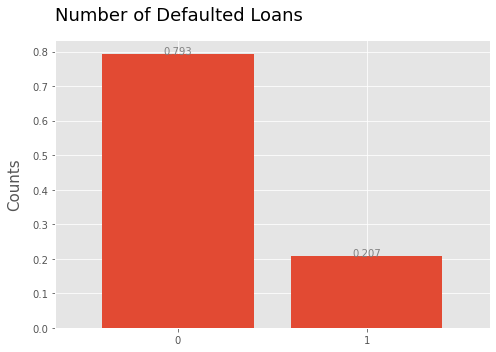

In [57]:
# plot bar chart of defaulted loan proportions
plt.figure(figsize=(7,5))
plt.style.use('ggplot')

# data = loan_df['Defaulted'].value_counts()
data = loan_df['Defaulted'].value_counts(normalize=True)

data.plot(kind='bar', width=0.8)

plt.title('Number of Defaulted Loans', fontsize=18, pad=20, loc='left')
plt.ylabel('Counts', labelpad=10, fontsize=15)
plt.xticks(rotation=0)


for i, v in enumerate(data):
    plt.text(i, v, round(v,3), ha='center', color='grey')

plt.tight_layout()
plt.show()

Here we see that the targe label is then a little imbalanced. Overall, the target label is properly constructed.

## Defaulted and Status

Another feature which seems to be relevant is the `Status` feature, which indicates the status of the loan as of the date of extraction 13/01/2021, irrespective of whether the loan has earlier defaulted or not.

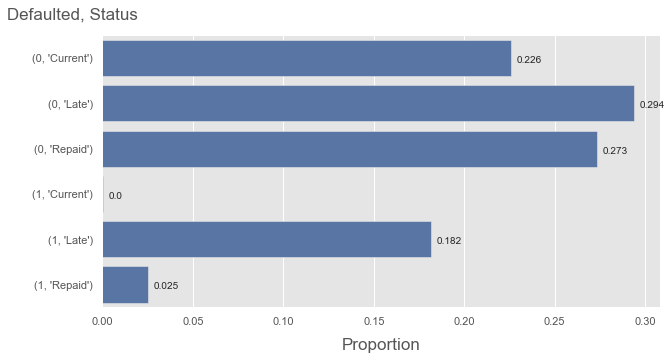

In [58]:
# groupby 'defaulted' and 'status'. find proportion
data = loan_df.groupby(['Defaulted','Status']).size()
data = data/sum(data)

# plot the % of defaulted loans, and their current status
sns.set(rc={'figure.figsize':(10,5)})
plt.style.use('ggplot')

ax = sns.barplot(data=data, orient='h', color='b')
ax.set_yticklabels(data.index)
ax.set_ylabel('Defaulted, Status', fontsize=17, y=1.05,horizontalalignment='left', labelpad=25, rotation=0)
ax.set_xlabel('Proportion', fontsize=17, labelpad=11)

for i, v in enumerate(data):
    plt.text(v+0.003, i+0.1, round(v,3))

# plt.tight_layout()
plt.show()

Here we see that a large proportion of the defaulted loans as earlier defined are still late in payments as of 13/01/2021, but a small portion (~2% of total loans) gets repaid. 

Conversely, we see that there are also a huge proportion of non-defaulted loans which are late in payments as of 13/01/2021. Overall, we see that the `Status` feature is not useful as it is not a POA data, given that it is refreshed as of 13/01/2021. We will remove this from future dataset.

# Feature Construction

We will proceed next to create a subset of features that are available to UOB at the point of application. 

These are the personal information fields found in the MyInfo requests and the loan application forms that the customer submits during application.

We will also construct additional credit history related features at this stage. Such features should and can be cosntructed at the point of application, drawing relevant data and values from databases via ETL processes, e.g. getting payment history from existing databases.

This process where new incoming transactions is checked against a set of older transaction data or other database to create new feature fields can be part of the data pipeline as an early state ETL process.

> __However, an important point to note that in real operation, new transactions can only view data in the databases that are earlier than said transaction. This will be adhered to in our context__


## IncomeTotal

Generally at POA, applicants would declare their principal income amount, as well as income from other sources. We will thus proceeed to combine incomes from sources other than the principal employeer & leave pay as a single variable `IncomeFromSalary`, as they are generally provided by employment, and combine the others into a single variable, `IncomeFromOthers`.

In [59]:
loan_df['IncomeFromSalary'] = loan_df['IncomeFromPrincipalEmployer'] + loan_df['IncomeFromLeavePay']
loan_df['IncomeFromOthers'] = loan_df['IncomeFromChildSupport'] + loan_df['IncomeFromFamilyAllowance'] + loan_df['IncomeFromPension'] + loan_df['IncomeFromSocialWelfare'] + loan_df['IncomeOther']

loan_df[['IncomeTotal', 'IncomeFromSalary', 'IncomeFromOthers']]

,IncomeTotal,IncomeFromSalary,IncomeFromOthers
1,697.0,0.0,697.0
2,970.0,970.0,0.0
3,745.0,745.0,0.0
5,2590.0,2590.0,0.0
7,550.0,550.0,0.0
...,...,...,...
109878,350.0,350.0,0.0
109879,1000.0,1000.0,0.0
109882,1169.0,624.0,545.0
109883,550.0,550.0,0.0


## Credit Related Features

An important set of features for any credit application analytics is the credit history. In our context, while we are specifically looking at thin-file clients, we would still expect some clients to have some prior credit history with the financial institution. Whether such thin credit history will affect our model is also a key question for our study.

There are a number of credit history related features already provided, e.g. `NoOfPreviousLoansBeforeLoan`, `AmountOfPreviousLoansBeforeLoan`,`PreviousEarlyRepaymentsBeforeLoan`, `PreviousRepaymentsBeforeLoan`, `PreviousEarlyRepaymentsCountBeforeLoan`, `DebtToIncome`, `ExistingLiabilities`, `LiabilitiesTotal` and `NoOfEarlierDefaults`. Lets do a quick study on these features.

### NoOfPreviousLoansBeforeLoan

One of the possible feature that any loan application keyed into the bank system would be the number of earlier loans the applicants have with the bank.

In the current dataset, there is a feature `NoOfPreviousLoansBeforeLoan` which represents this. However, as we have done a round of subsetting, lets check if the values is still correct.

In [60]:
# define function that takes in a series/dataframe and counts the number of rows having dates earlier
def count_earlier(df):
    return df.apply(lambda x: sum(x > df))

In [61]:
# Create variable NrEarlierLoans
loan_df['NrEarlierLoans'] = loan_df.groupby(['UserName'])['LoanApplicationStartedDate'].transform(count_earlier)

In [62]:
# check if the processing is done correctly
loan_df[loan_df['NrEarlierLoans'] > 9].UserName.head()

33733    BO7763A73
33772    BO7763A73
33953    BO7763A73
51534    BOKKA6993
51674    BOKKA6993
Name: UserName, dtype: object

In [63]:
# check records for BOKKA6993
loan_df.loc[loan_df['UserName'] =='BOKKA6993', ['LoanId', 'NoOfPreviousLoansBeforeLoan', 'NrEarlierLoans']]

,LoanId,NoOfPreviousLoansBeforeLoan,NrEarlierLoans
43121,236A3F17-8CED-4239-AF67-A97E016BA070,0,0
46024,3649C5A4-ECA0-46E5-AC58-A99D00EC9AF5,2,2
47651,6B4792F3-0DD9-4744-B319-A9840007981C,1,1
48007,5F97E94E-009C-4266-9B02-A9C8005C3FEA,5,5
49885,708D1972-A7C8-48E4-90BD-A9A90125E867,3,3
50566,A7465C96-870A-443E-B6ED-A9EC013DA1DA,8,8
51534,24E0D321-54E8-42E7-BEFF-AA040146BA58,10,10
51674,FA65111C-7848-4053-8DF6-AA080111AC8C,11,11
52792,34448556-0B00-4B39-9E97-A9C0012B4CFE,4,4
53845,C57FEEB9-5C4D-492C-88E4-A9DE013462F2,6,6


In [64]:
loan_df['NrEarlierLoans'].value_counts(dropna=False)

0     51688
1     14684
2      4549
3       919
4        65
5        26
6        14
7         9
8         6
9         3
12        2
11        2
10        2
Name: NrEarlierLoans, dtype: int64

The `NrEarlierLoans` seem to be constructed corretly. Lets counter check if `NoOfPreviousLoansBeforeLoan` is equal to `NrEarlierLoans` for all loans.

In [65]:
# counter check with if there are any loans where NrEarlierLoans != NoOfPreviousLoansBeforeLoan
loan_df.loc[loan_df['NrEarlierLoans'] != loan_df['NoOfPreviousLoansBeforeLoan']]

,LoanId,UserName,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,LanguageCode,Age,Gender,Country,AppliedAmount,...,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,VerificationType,Defaulted,IncomeFromSalary,IncomeFromOthers,NrEarlierLoans


We find that there are no loan appications where `NoOfPreviousLoansBeforeLoan` is not equal to `NrEarlierLoans`. Hence we can keep the feature `NoOfPreviousLoansBeforeLoan`.

### AmountOfPreviousLoansBeforeLoan

Next, lets explore the variable `AmountOfPreviousLoansBeforeLoan` which should represent the total value of earlier loans obtained by the applicant before the said loan. Given that we have done some data subsetting earlier, the `AmountOfPreviousLoansBeforeLoan` may have incorrectly captured the total amount of loans within the 6 months period.

Lets do a counter check. Let us calculate our own version of the variable `AmountOfPreviousLoans`.

In [66]:
# sort loan_df by username and then loanapplicationstarteddate
loan_df = loan_df.sort_values(['UserName', 'LoanApplicationStartedDate'])

In [67]:
%%cython
# define function that creates 'AmountOfPreviousLoans'
def find_earlier_loan_amount(x):
    
    # at each row/loan, gets the sum of the loan amounts before the current row. Since the dataframe has been sorted according to date, it sums the earlier loan amounts
    x['AmountOfPreviousLoans'] = x['Amount'].cumsum().shift(1, fill_value=0)
    
    return x 

In [68]:
# groupby username and apply function
loan_df = loan_df.groupby('UserName').apply(find_earlier_loan_amount)

Lets check our derived values and that provided by the dataset

In [69]:
# check if there is equivalence between the two AmountOfPreviousLoans and AmountOfPreviousLoansBeforeLoan variables
(np.round(loan_df['AmountOfPreviousLoansBeforeLoan'], 2) == np.round(loan_df['AmountOfPreviousLoans'], 2)).value_counts()

True    71969
dtype: int64

We see that they all coincide.

We find that there are no loan appications where `AmountOfPreviousLoans` is not equal to `AmountOfPreviousLoansBeforeLoan`. Hence we can keep the feature `AmountOfPreviousLoansBeforeLoan`.

### PreviousRepaymentsBeforeLoan

Next, we will investigate the feature, `PreviousRepaymentsBeforeLoan` which captures the total amount repaid to the previous loans borrowed, before the current application. It is an important feature that captures how profitable the client has been, and also represents the risk involved, if there is a large outstanding amount left to paid on previous loans.

First lets calculate an equivalent feature. We will use the repay_df dataframe which contains all the repayments transations.

In [70]:
# first lets sort by username and loan application date
loan_df.sort_values(['UserName', 'LoanApplicationStartedDate'], inplace=True, ignore_index=True)

In [71]:
# next lets get all the repayment details of all the loans present in loan_df
repay_df_1 = repay_df.loc[repay_df['loan_id'].isin(loan_df['LoanId'])].copy()

# next, lets sort the the repayments data by date (ascending)
repay_df_1.sort_values(['Date'], inplace=True, ignore_index=True)

# for each payment in repay_df, find the total payment
repay_df_1['total'] = repay_df_1['PrincipalRepayment'] + repay_df_1['InterestRepayment'] + repay_df_1['LateFeesRepayment']

repay_df_1 = repay_df_1.loc[:,['loan_id', 'Date','total']].copy()

In [72]:
%%cython
# define user funtion that takes in grouped object by username
def get_prior_repayments(grp_obj, repay_df):
    
    # gets a subset from repay_df belonging to loanids in grouped object
    pay_df = repay_df.loc[repay_df['loan_id'].isin(grp_obj['LoanId'])].sort_values('Date')
    
    # gets cummulative sum of all the earliier and current repayments  
    pay_df['cumtotal'] = pay_df['total'].cumsum()
    
    # for each loan date in grouped object, find the cummulative sum of repayments from pay_df up to said loan date, for loan dates with no earlier repayment, fill with 0
    grp_obj['PriorRepayments'] = (grp_obj['LoanApplicationStartedDate'].apply(lambda x: pay_df.loc[pay_df['Date'] < x, 'cumtotal'].max())).fillna(0)
        
    return grp_obj

In [73]:
# group loan_df by username and then apply get_prior_repayments
loan_df = loan_df.groupby('UserName').apply(get_prior_repayments, repay_df=repay_df_1)

In [74]:
# check if PriorRepyaments and PreviousRepaymentsBeforeLoan are equivalent
(loan_df['PriorRepayments'] == loan_df['PreviousRepaymentsBeforeLoan']).value_counts(dropna=False)

False    40250
True     31719
dtype: int64

Turns out that there is a large number of loan applications where `PriorRepyaments` and `PreviousRepaymentsBeforeLoan` are not equal. Lets check thos

In [75]:
# check which loan applications have none equal PriorRepyaments and PreviousRepaymentsBeforeLoan
loan_df.loc[~(loan_df['PriorRepayments'] == loan_df['PreviousRepaymentsBeforeLoan']), ['UserName', 'LoanId', 'LoanApplicationStartedDate', 'PreviousRepaymentsBeforeLoan', 'PriorRepayments']]

,UserName,LoanId,LoanApplicationStartedDate,PreviousRepaymentsBeforeLoan,PriorRepayments
1,0505sveta,6366455E-BA72-4A05-BC7F-AB2B00FAEA88,2019-12-22 15:13:00,NaN,0.0000
7,13Maximus13,EC263FDB-6298-4E1D-A4DE-9D9301231698,2010-06-12 17:39:00,189.3010,189.3010
8,13Maximus13,F6E2D64D-E2E1-42F0-9D12-9DB500D1944B,2010-07-16 12:43:00,320.7856,320.7856
14,1990kos,B6C6355C-7DF1-4184-8DAA-AA9200A90773,2019-07-22 10:15:00,NaN,0.0000
25,39009297010,D61D7A2C-340A-4CAD-9EC8-AB6500DF0518,2020-02-18 13:31:00,NaN,0.0000
...,...,...,...,...,...
71955,zimmy22,C3CF3FCF-F68F-4490-83DA-AB8F011BCBE3,2020-03-31 17:13:00,NaN,0.0000
71962,zvezdo4ka,49922301-FEF2-4E0B-9716-AA610126964C,2019-06-03 17:52:00,NaN,0.0000
71966,Артур Зинатов,A831C3B1-8D96-4B13-8DAF-A9B300D956FA,2018-12-11 13:11:00,NaN,0.0000
71967,людмила,1612812E-3001-47EB-BDB2-AB3200A63E2A,2019-12-29 10:05:00,NaN,0.0000


Here we see that it is likely that a portion of these have NaN `PreviousRepaymentsBeforeLoan` which would have 0 `PriorRepyaments`. We also see that some seem to have equal values but conditionally be unequal as a result of unequal float comparison.

In [76]:
# lets first round both values to 3 decimal places and test for equivalence.
loan_df.loc[~(round(loan_df['PriorRepayments'],3) == round(loan_df['PreviousRepaymentsBeforeLoan'], 3)), ['UserName', 'LoanId', 'LoanApplicationStartedDate', 'PreviousRepaymentsBeforeLoan', 'PriorRepayments']]

,UserName,LoanId,LoanApplicationStartedDate,PreviousRepaymentsBeforeLoan,PriorRepayments
1,0505sveta,6366455E-BA72-4A05-BC7F-AB2B00FAEA88,2019-12-22 15:13:00,NaN,0.0
14,1990kos,B6C6355C-7DF1-4184-8DAA-AA9200A90773,2019-07-22 10:15:00,NaN,0.0
25,39009297010,D61D7A2C-340A-4CAD-9EC8-AB6500DF0518,2020-02-18 13:31:00,NaN,0.0
44,56978311,4F1EB896-AAA5-47E2-8491-AB5000F68517,2020-01-28 14:57:00,NaN,0.0
61,AYRTO20,039D3B6B-A296-4F77-B2A0-ABC8000B1D3A,2020-05-27 00:40:00,NaN,0.0
...,...,...,...,...,...
71949,zamorano,04681373-369A-468E-8FB5-ABB90180BFFB,2020-05-12 23:20:00,NaN,0.0
71955,zimmy22,C3CF3FCF-F68F-4490-83DA-AB8F011BCBE3,2020-03-31 17:13:00,NaN,0.0
71962,zvezdo4ka,49922301-FEF2-4E0B-9716-AA610126964C,2019-06-03 17:52:00,NaN,0.0
71966,Артур Зинатов,A831C3B1-8D96-4B13-8DAF-A9B300D956FA,2018-12-11 13:11:00,NaN,0.0


In [77]:
# next, lets check the remaining values for NaN PreviousRepaymentsBeforeLoan
mask = (~(round(loan_df['PriorRepayments'],3) == round(loan_df['PreviousRepaymentsBeforeLoan'], 3))) & loan_df['PreviousRepaymentsBeforeLoan'].isna()

# get those transactions
data = loan_df.loc[mask, ['UserName', 'LoanId', 'LoanApplicationStartedDate', 'PreviousRepaymentsBeforeLoan', 'PriorRepayments']]

# check their corresponding PriorRepayments values
data['PriorRepayments'].value_counts(dropna=False)

0.00       31016
26.50          3
95.40          3
732.73         2
100.70         2
           ...  
100.10         1
442.75         1
154.21         1
531.38         1
1155.59        1
Name: PriorRepayments, Length: 501, dtype: int64

Here we see that although a large proportion of NaN `PreviousRepaymentsBeforeLoan` have corresponding 0 `PriorRepayments`, there are some deviations. Lets study further

In [78]:
mask = loan_df['PriorRepayments'] == 0

data = loan_df.loc[mask, ['UserName', 'LoanId', 'LoanApplicationStartedDate', 'PreviousRepaymentsBeforeLoan', 'PriorRepayments']]

data['PreviousRepaymentsBeforeLoan'].value_counts(dropna=False)

NaN       31016
0.00      20843
80.96         1
68.10         1
87.27         1
196.53        1
105.69        1
111.76        1
50.21         1
40.61         1
Name: PreviousRepaymentsBeforeLoan, dtype: int64

Here we consistently see that there are 31016 NaN  `PreviousRepaymentsBeforeLoan` having corresponding 0 `PriorRepayments`. We can add them to the filter.

In [79]:
mask = (~(round(loan_df['PriorRepayments'],3) == round(loan_df['PreviousRepaymentsBeforeLoan'], 3))) & (~(loan_df['PreviousRepaymentsBeforeLoan'].isna() & (loan_df['PriorRepayments']==0)))

diff_df = loan_df.loc[mask, ['UserName', 'LoanId', 'LoanApplicationStartedDate', 'PreviousRepaymentsBeforeLoan', 'PriorRepayments']]

diff_df

,UserName,LoanId,LoanApplicationStartedDate,PreviousRepaymentsBeforeLoan,PriorRepayments
126,Andy15,65B274A8-3B9B-46A7-90C5-AB3700D84A9A,2020-01-03 13:07:00,223.87,637.02
127,Andy15,47BBD69D-705D-4BEC-A950-AB74007F5154,2020-03-04 07:43:00,344.80,1358.79
160,Arno Proode,F41219D7-E7E2-4351-9017-A25A0089D6E1,2013-10-17 08:21:00,704.25,5877.62
186,BO1111139,08382BB0-1551-4599-8FDF-AB33014803D1,2019-12-30 19:54:00,438.47,665.65
198,BO1112137,FD053E65-32F5-4010-9814-A8CA008B72BB,2018-04-22 08:27:00,NaN,191.68
...,...,...,...,...,...
71829,valve,457E856B-41B9-4509-970D-A9EE000F11E3,2019-02-08 00:54:00,62.91,79.79
71840,vatsliku,B6835049-1871-477C-AA20-ABC100AC010C,2020-05-20 10:26:00,916.25,1444.11
71846,veiko1234,060A77A3-8AF1-4A32-9447-9F91014C367D,2011-11-04 20:09:00,473.68,383.95
71849,veikokidra,148B31CC-B23E-4A9D-9B6F-AB0600B67A4A,2019-11-15 11:04:00,630.91,4238.80


Here we have a remaining 5128 transactions which have different` PreviousRepaymentsBeforeLoan` and  `PriorRepayments`. Lets explore further:

In [80]:
# get random transaction from above list
rand_trans = diff_df.sample()
rand_trans

,UserName,LoanId,LoanApplicationStartedDate,PreviousRepaymentsBeforeLoan,PriorRepayments
37980,BO6646A73,6441439A-5ABD-4525-B1B9-AB7D01281D49,2020-03-13 17:58:00,496.32,879.06


In [81]:
# get all loan appliations from username of rand_trans
rand_loans = loan_df.loc[loan_df['UserName'].isin(rand_trans['UserName'])]
rand_loans[['UserName', 'LoanId', 'LoanApplicationStartedDate', 'LoanDate', 'PreviousRepaymentsBeforeLoan', 'PriorRepayments']]

,UserName,LoanId,LoanApplicationStartedDate,LoanDate,PreviousRepaymentsBeforeLoan,PriorRepayments
37978,BO6646A73,FC06F5D8-8D2E-4E6B-9399-AAD9010F6F5D,2019-10-01 16:28:00,2019-10-01,NaN,0.00
37979,BO6646A73,60391A10-6E8D-4D0C-A250-AB17012EC53D,2019-12-02 18:22:00,2019-12-02,185.04,185.04
37980,BO6646A73,6441439A-5ABD-4525-B1B9-AB7D01281D49,2020-03-13 17:58:00,2020-03-13,496.32,879.06


Pay attention to which loans have different `PreviousRepaymentsBeforeLoan` and  `PriorRepayments` and take note of the `LoanApplicationStartedDate`.

In [82]:
# get all equivalent repayment transactions from repay_df
rand_repay = repay_df.loc[repay_df['loan_id'].isin(rand_loans['LoanId'])].sort_values("Date")

# get the cummulative sum column
rand_repay['cumtotal'] = (rand_repay['PrincipalRepayment'] + rand_repay['InterestRepayment'] + rand_repay['LateFeesRepayment']).cumsum()

rand_repay

,ReportAsOfEOD,loan_id,Date,PrincipalRepayment,InterestRepayment,LateFeesRepayment,cumtotal
2361785,2021-01-12,FC06F5D8-8D2E-4E6B-9399-AAD9010F6F5D,2019-10-21,51.88,29.40,0.0,81.28
2361786,2021-01-12,FC06F5D8-8D2E-4E6B-9399-AAD9010F6F5D,2019-11-19,51.88,51.88,0.0,185.04
2434979,2021-01-12,60391A10-6E8D-4D0C-A250-AB17012EC53D,2019-12-18,69.17,36.89,0.0,291.10
2361787,2021-01-12,FC06F5D8-8D2E-4E6B-9399-AAD9010F6F5D,2019-12-18,51.88,51.88,0.0,394.86
2361788,2021-01-12,FC06F5D8-8D2E-4E6B-9399-AAD9010F6F5D,2020-01-21,51.88,51.88,0.0,498.62
1707902,2021-01-12,60391A10-6E8D-4D0C-A250-AB17012EC53D,2020-01-21,69.17,69.17,0.0,636.96
2434980,2021-01-12,60391A10-6E8D-4D0C-A250-AB17012EC53D,2020-02-20,69.17,69.17,0.0,775.30
1633756,2021-01-12,FC06F5D8-8D2E-4E6B-9399-AAD9010F6F5D,2020-02-20,51.88,51.88,0.0,879.06
1707903,2021-01-12,60391A10-6E8D-4D0C-A250-AB17012EC53D,2020-03-19,69.17,69.17,0.0,1017.40
2361789,2021-01-12,FC06F5D8-8D2E-4E6B-9399-AAD9010F6F5D,2020-03-19,51.88,51.88,0.0,1121.16


Now find the cumtotal of the repayments at a date earlier than the previously highlighted `LoanApplicationStartedDate` . Now assuming that the repayments dataset remains unmodified, it does seem that the `PriorRepayments` feature that we developed should take precedence over the `PreviousRepaymentsBeforeLoan` feature.

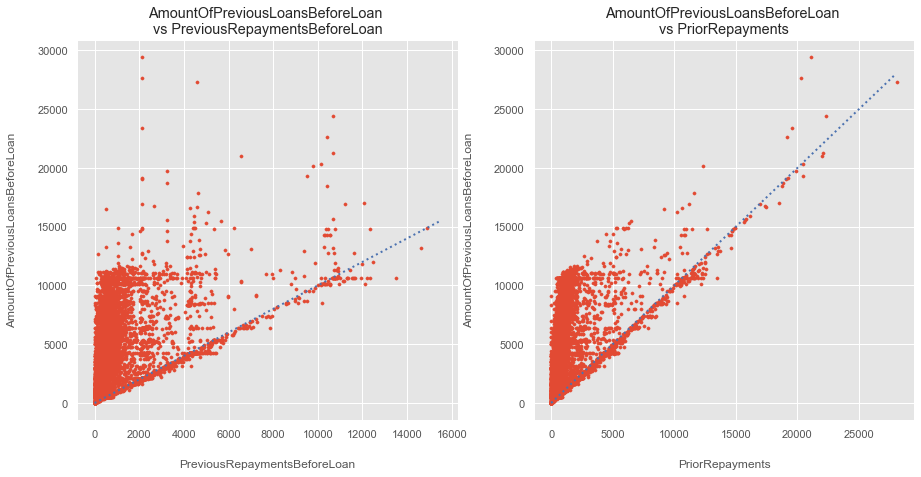

In [83]:
# scatter plot of previousrepaymentsbeforeloan against amountofpreviousloansbeforeloan
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

ax1.scatter(x='PreviousRepaymentsBeforeLoan', y='AmountOfPreviousLoansBeforeLoan', data=loan_df, s=10)
ax1.plot(np.linspace(0, 1.55*10**4, 10), np.linspace(0, 1.55*10**4, 10), color='b', linestyle=':', lw=2)

ax1.set(title='AmountOfPreviousLoansBeforeLoan \nvs PreviousRepaymentsBeforeLoan')
ax1.set_xlabel('PreviousRepaymentsBeforeLoan', labelpad=20)
ax1.set_ylabel('AmountOfPreviousLoansBeforeLoan', labelpad=20)

ax2.scatter(x='PriorRepayments', y='AmountOfPreviousLoansBeforeLoan', data=loan_df, s=10)
ax2.plot(np.linspace(0, 2.8*10**4, 10), np.linspace(0, 2.8*10**4, 10), color='b', linestyle=':', lw=2)

ax2.set(title='AmountOfPreviousLoansBeforeLoan \nvs PriorRepayments')
ax2.set_xlabel('PriorRepayments', labelpad=20)
ax2.set_ylabel('AmountOfPreviousLoansBeforeLoan', labelpad=20)

plt.show()

We see that in general, the values of `PreviousRepaymentsBeforeLoan` and `PriorRepayments` is generally lesser than or just slightly more than the `AmountOfPreviousLoansBeforeLoan`, given that you typically would not be able to repay more than what you have borrowed plus interest, unless, you have incurred other costs such as late fees etc.

We also see that `PriorRepayments` seems to hold truer to the above statement than `PreviousRepaymentsBeforeLoan`. 

As such we will adopt the `PriorRepayments` feature created.

### PreviousEarlyRepaymentsCountBeforeLoan

Next we explore the `PreviousEarlyRepaymentsCountBeforeLoan` variable, which captures the total counts of early repayments on loans before the current loan application. From the repayments dataset and the loans dataset solely, it is not possible to calculate our own version of this feature as we do not have the payment schedules for each loan application and thus we are unable to find which payments are early.

Thus, we will explore the existing `PreviousEarlyRepaymentsCountBeforeLoan` feature to see if we can interpret and thus use it.

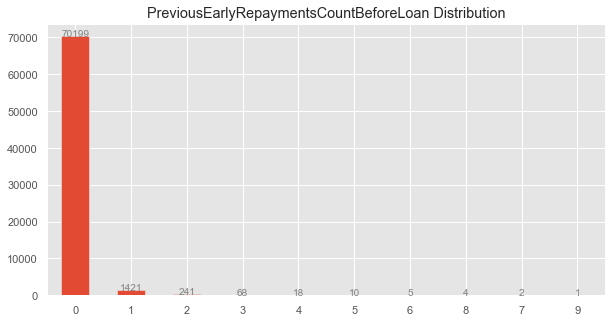

In [84]:
# check the distribution
data = loan_df['PreviousEarlyRepaymentsCountBeforeLoan'].value_counts(dropna=False)

data.plot(kind='bar',  figsize=(10, 5), title='PreviousEarlyRepaymentsCountBeforeLoan Distribution', rot=0)

for i, v in enumerate(data):
    plt.text(i, v, round(v,3), ha='center', color='grey')

plt.show()

We see that there are a lot of zeros in the `PreviousEarlyRepaymentsCountBeforeLoan`, more than 90%. There are no NaNs.  Lets plot it with respect to `PreviousEarlyRepaymentsBeforeLoan` which is another feature of interest that consolidates the total amount of early repayments before the loan. In theory, when `PreviousEarlyRepaymentsCountBeforeLoan` == 0, `PreviousEarlyRepaymentsBeforeLoan` must == 0.

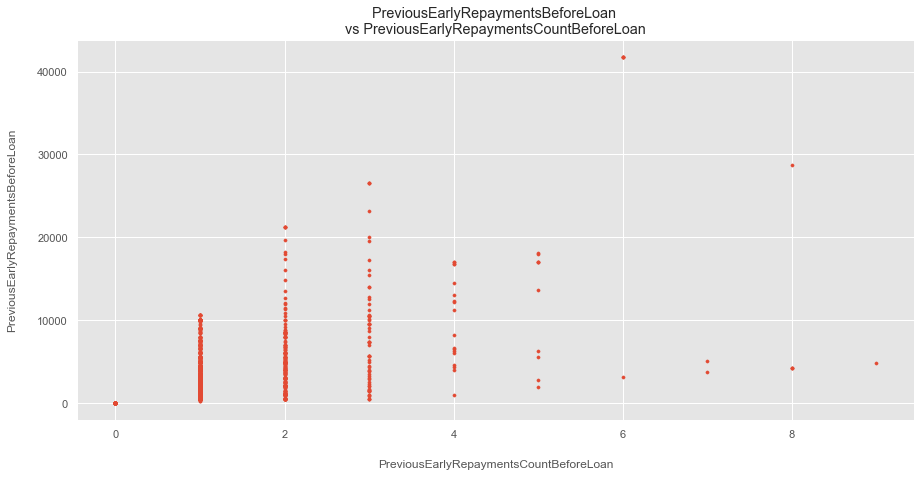

In [85]:
# scatter plot of PreviousEarlyRepaymentsBeforeLoan against PreviousEarlyRepaymentsCountBeforeLoan
plt.style.use('ggplot')
fig, ax = plt.subplots( figsize=(15,7))

ax.scatter(x='PreviousEarlyRepaymentsCountBeforeLoan', y='PreviousEarlyRepaymentsBeforeLoan', data=loan_df, s=10)

ax.set(title='PreviousEarlyRepaymentsBeforeLoan \nvs PreviousEarlyRepaymentsCountBeforeLoan')
ax.set_xlabel('PreviousEarlyRepaymentsCountBeforeLoan', labelpad=20)
ax.set_ylabel('PreviousEarlyRepaymentsBeforeLoan', labelpad=20)



plt.show()

The theory holds and there does not seem to be any issue with `PreviousEarlyRepaymentsCountBeforeLoan`.

### PreviousEarlyRepaymentsBeforeLoan

Lets explore the last `PreviousEarlyRepaymentsBeforeLoan` feature. Again we face the same issue as the `PreviousEarlyRepaymentsCountBeforeLoan` feature and so we will again explore the feature.

Lets first check the distribution

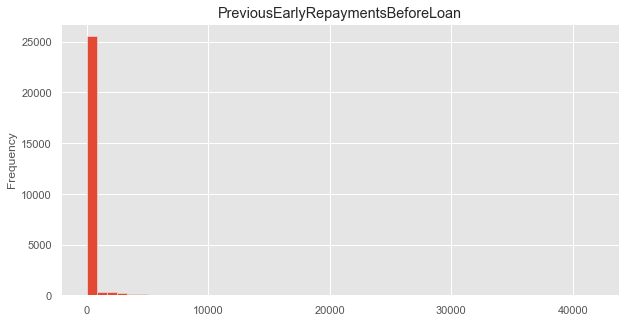

In [86]:
# check the distribution
data = loan_df['PreviousEarlyRepaymentsBeforeLoan']

data.plot(kind='hist', bins=50, figsize=(10, 5), title='PreviousEarlyRepaymentsBeforeLoan')


plt.show()

Again a huge number of zeros which is reasonable, given that the early loan repayment is not something borrowers often do.

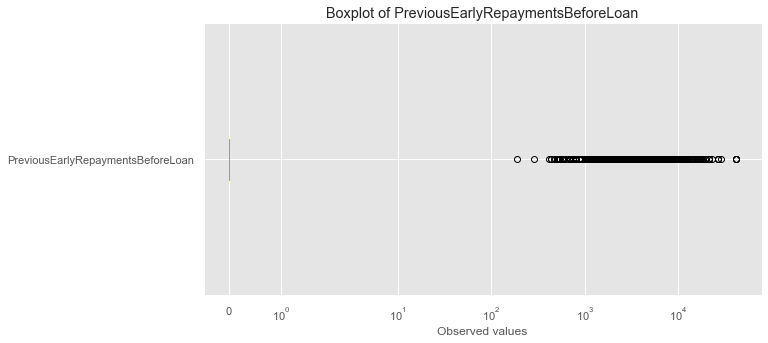

In [87]:
data = loan_df[['PreviousEarlyRepaymentsBeforeLoan']]

fig, ax = plt.subplots()

ax = data.boxplot(vert=False, patch_artist=True)

ax.set_xscale('symlog')
ax.set(title='Boxplot of PreviousEarlyRepaymentsBeforeLoan', xlabel='Observed values')

plt.show()

We see alot of outliers, a zero-inflation problem. Lets check the number of missing values.

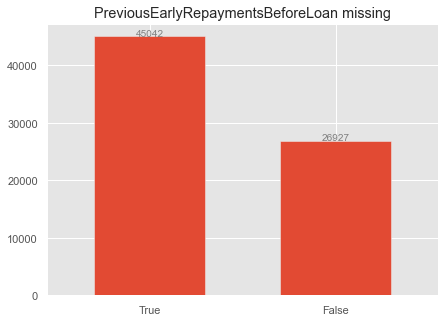

In [88]:
# how much previousearlyrepaymentsbeforeloan is missing
data= loan_df['PreviousEarlyRepaymentsBeforeLoan'].isna().value_counts()

plt.style.use("ggplot")
data.plot(kind='bar', figsize=(7,5), width=0.6, rot=0, title='PreviousEarlyRepaymentsBeforeLoan missing')

for i, v in enumerate(data):
    plt.text(i, v, round(v,3), ha='center', color='grey')

A huge number of missing values > 60%. Lets check the distribution of the target variable vs when `PreviousEarlyRepaymentsBeforeLoan` is missing and when it is not missing

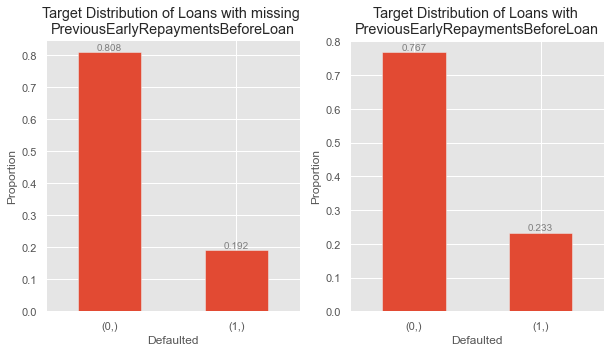

In [89]:
# check the distribution of the targe variable of the loans
data1 = loan_df.loc[loan_df['PreviousEarlyRepaymentsBeforeLoan'].isna(), ['Defaulted']].value_counts(normalize=True)

data2 = loan_df.loc[loan_df['PreviousEarlyRepaymentsBeforeLoan'].notna(), ['Defaulted']].value_counts(normalize=True)

fig, (ax1, ax2) = plt.subplots(1, 2)


data1.plot(kind='bar', rot=0, ylabel='Proportion', xlabel='Defaulted', title='Target Distribution of Loans with missing \nPreviousEarlyRepaymentsBeforeLoan', ax=ax1)

for i, v in enumerate(data1):
    ax1.text(i, v+0.007, round(v,3), ha='center', color='grey')

data2.plot(kind='bar', rot=0, ylabel='Proportion', xlabel='Defaulted', title='Target Distribution of Loans with \nPreviousEarlyRepaymentsBeforeLoan', ax=ax2)


for i, v in enumerate(data2):
    ax2.text(i, v+0.007, round(v,3), ha='center', color='grey')

    
plt.show()

We see that there are some differences in the distribution of the target variable when `PreviousEarlyRepaymentsBeforeLoan` is missing as compared to the standard population distribution. 

Lets check its relationship with `PreviousRepaymentsBeforeLoan`, `AmountOfPreviousLoans`.

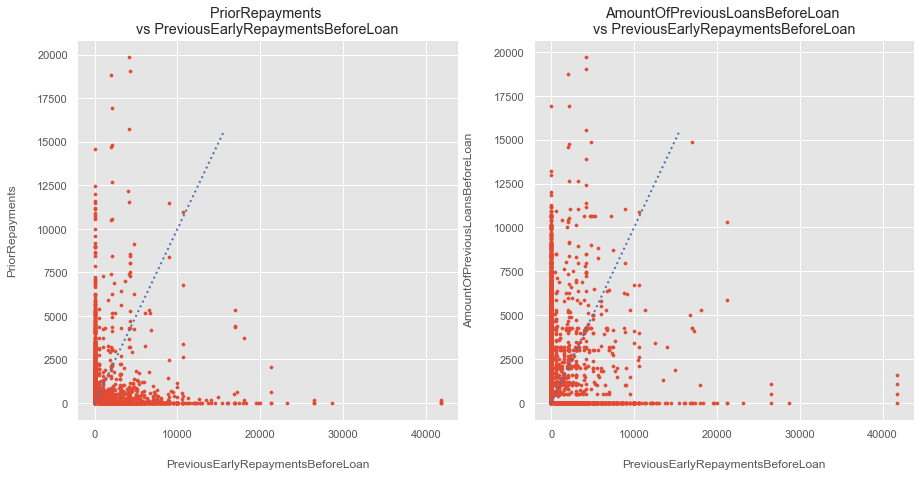

In [90]:
# scatter plots of PreviousEarlyRepaymentsBeforeLoan against PriorRepayments and AmountOfPreviousLoansBeforeLoan
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

ax1.scatter(x='PreviousEarlyRepaymentsBeforeLoan', y='PriorRepayments', data=loan_df, s=10)
ax1.plot(np.linspace(0, 1.55*10**4, 10), np.linspace(0, 1.55*10**4, 10), color='b', linestyle=':', lw=2)

ax1.set(title='PriorRepayments \nvs PreviousEarlyRepaymentsBeforeLoan')
ax1.set_xlabel('PreviousEarlyRepaymentsBeforeLoan', labelpad=20)
ax1.set_ylabel('PriorRepayments', labelpad=20)

ax2.scatter(x='PreviousEarlyRepaymentsBeforeLoan', y='AmountOfPreviousLoansBeforeLoan', data=loan_df, s=10)
ax2.plot(np.linspace(0, 1.55*10**4, 10), np.linspace(0, 1.55*10**4, 10), color='b', linestyle=':', lw=2)

ax2.set(title='AmountOfPreviousLoansBeforeLoan \nvs PreviousEarlyRepaymentsBeforeLoan')
ax2.set_xlabel('PreviousEarlyRepaymentsBeforeLoan', labelpad=20)
ax2.set_ylabel('AmountOfPreviousLoansBeforeLoan', labelpad=20)

plt.show()

Here we see a number of glaring issues with the feature `PreviousEarlyRepaymentsBeforeLoan`. The `PreviousEarlyRepaymentsBeforeLoan` should not exceed the value of `AmountOfPreviousLoansBeforeLoan` and `PriorRepayments` as the total quantum of early repayments on early loans should not exceed the total value of the previous loans by much nor should it exceed the total repayments made to the previous loans represented by `PriorRepayments`.

This brings about the question on `PreviousEarlyRepaymentsCountBeforeLoan`. It is likely that this feature captures early loan repayment counts outside of the dataset. By extension, `PreviousEarlyRepaymentsCountsBeforeLoan` incorporates loan/credit history outside the dataset.

It is possible that these features includes early repayment amounts for other loans perhaps not captured in the dataset, or from other credit history extracted from other agencies. We will keep these 2 features.

### NoOfEarlierDefaults

The last feature we would consider would be the `NoOfEarlierDefaults` feature, a self-constructed feature which indicates the number of earlier defaulted loans from the point of each loan application. As we have earlier redefined our default definition to be occurring within 6 months of the loan disbursement and we have earlier restricted our dataset to have max 6 months view of transactions.

We may use direct comparision between `DefaultDate` against `LoanApplicationStartedDate` to calculate if there are any defaults happening 6 monthe earlier from current loan application.

In [91]:
# function that takes in dataframe, compares each loan application date of each row to all the default dates in the dataframe and returns the number of loans which have 
# an earlier default date
def earlier_defaults(df, loan, default):
    return df[loan].apply(lambda x: sum(x > df[default])).to_frame()

In [92]:
loan_df['NoOfEarlierDefaults'] = loan_df.groupby('UserName').apply(earlier_defaults, loan='LoanApplicationStartedDate', default='DefaultDate')

In [93]:
# check if the variable is constructed correctly
loan_df.loc[loan_df['NoOfEarlierDefaults'] !=0]

,LoanId,UserName,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,LanguageCode,Age,Gender,Country,AppliedAmount,...,PreviousEarlyRepaymentsBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,VerificationType,Defaulted,IncomeFromSalary,IncomeFromOthers,NrEarlierLoans,AmountOfPreviousLoans,PriorRepayments,NoOfEarlierDefaults
9005,F07472D9-19A2-47BC-926D-AB390147B42E,BO23K7KA1,False,2020-01-05 19:53:00,2020-01-05,6,29,2,ES,4253.0,...,NaN,0,4,1,0.0,0.0,1,1910.0,1403.19,1
19721,02CAFE2A-B5A8-44C2-9184-A64E00AC05AE,BO3A64373,False,2016-07-25 10:26:00,2016-07-26,6,31,1,ES,2125.0,...,0.0,0,4,0,983.0,0.0,1,305.0,392.63,1
28523,84C54837-7406-45C4-AEEE-AABF0112160C,BO5236946,False,2019-09-05 16:37:00,2019-09-05,4,68,1,FI,8750.0,...,NaN,0,4,0,0.0,0.0,1,2550.0,884.71,1
46967,9802C905-DD0E-4E32-9D21-AB1A00EB9862,BO7A53936,False,2019-12-05 14:17:00,2019-12-05,6,23,0,ES,4253.0,...,NaN,0,4,1,0.0,0.0,1,2125.0,1431.86,1
51095,CBEB9D5D-A6DB-46DC-80FF-A86D00DD5F15,BO9553471,False,2018-01-19 13:33:00,2018-01-21,6,23,2,ES,530.0,...,0.0,0,4,0,0.0,0.0,2,1060.0,1230.07,1
60288,2D5CF664-4397-4281-AB17-AB250106397E,BOA99K292,False,2019-12-16 15:54:00,2019-12-16,6,26,0,ES,1275.0,...,NaN,0,4,0,0.0,0.0,1,2125.0,1530.36,1
63435,C1DA87BE-369E-403D-806D-AAED00B93D7B,BOK36624,False,2019-10-21 11:14:00,2019-10-21,4,27,1,FI,3113.0,...,NaN,0,4,1,0.0,0.0,1,2125.0,1776.14,1
67913,C804450C-481B-4543-8358-AB8700A7664A,BOKAKA136,False,2020-03-23 10:08:00,2020-03-23,4,39,0,FI,4150.0,...,NaN,0,4,0,0.0,0.0,1,2594.0,1775.46,1
68042,8207A8AC-7397-43A0-864E-A4F80183E964,BOKK2713A,False,2015-08-18 23:32:00,2015-08-22,6,26,0,ES,1500.0,...,0.0,0,3,1,1000.0,0.0,1,1000.0,1235.29,1


In [94]:
loan_df['NoOfEarlierDefaults'].value_counts(dropna=False)

0    71960
1        9
Name: NoOfEarlierDefaults, dtype: int64

We see that a majority of the loans however, are applied when prior loans are not in default. Overall, the feature is constructed correctly.

In [95]:
# investigate BO9553471
loan_df.loc[loan_df['UserName']=='BO9553471', ['LoanId', 'LoanApplicationStartedDate', 'DefaultDate', 'Defaulted', 'NoOfEarlierDefaults']]

,LoanId,LoanApplicationStartedDate,DefaultDate,Defaulted,NoOfEarlierDefaults
51093,94BC979D-840A-45AD-91EA-A79A012B26D6,2017-06-22 18:09:00,NaT,0,0
51094,2D02A8E7-514B-4E0A-B229-A7B800155F93,2017-07-22 01:17:00,2017-11-21,1,0
51095,CBEB9D5D-A6DB-46DC-80FF-A86D00DD5F15,2018-01-19 13:33:00,NaT,0,1


# POA List of Features

Having subsetted the dataset and created some POA features, we can further refine the list of features to be in the POA dataset:
```python
Target = ['Defaulted']

Loan identifiers = ['LoanId', 'UserName']

Personal attributes = ['LanguageCode', 'Age', 'Gender', 'Country', 'Education', 'MaritalStatus', 'NrOfDependants',
                      'HomeOwnershipType']

Employment details = ['EmploymentDurationCurrentEmployer', 'EmploymentStatus', 'OccupationArea', 'WorkExperience']

Loan details = ['AppliedAmount', 'Interest', 'LoanDuration', 'LoanApplicationStartedDate']

Income details = ['IncomeTotal', 'IncomeFromSalary', 'IncomeFromOthers']

Credit details = ['NoOfPreviousLoansBeforeLoan','AmountOfPreviousLoansBeforeLoan', 'PriorRepayments',
                  'NoOfEarlierDefaults', 'ExistingLiabilities', 'LiabilitiesTotal','DebtToIncome',
                  'PreviousEarlyRepaymentsBeforeLoan','PreviousEarlyRepaymentsCountBeforeLoan']

```

In [98]:
# subset to obtain POA data
final_col = ['Defaulted', 'LoanId','UserName', 'LoanApplicationStartedDate',
       'LanguageCode', 'Age', 'Gender', 'Country', 'AppliedAmount',
       'Interest', 'LoanDuration','Education', 'MaritalStatus', 'NrOfDependants',
       'EmploymentStatus', 'EmploymentDurationCurrentEmployer', 'WorkExperience', 'OccupationArea',
       'HomeOwnershipType', 'IncomeTotal', 'IncomeFromSalary', 'IncomeFromOthers', 
       'ExistingLiabilities', 'LiabilitiesTotal','DebtToIncome', 'NoOfEarlierDefaults',
       'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan', 'PriorRepayments', 
       'PreviousEarlyRepaymentsBeforeLoan','PreviousEarlyRepaymentsCountBeforeLoan']

In [99]:
# create POA dataset
poa_df = loan_df[final_col]

In [100]:
poa_df.shape

(71969, 31)

In [101]:
poa_df['Defaulted'].value_counts()

0    57069
1    14900
Name: Defaulted, dtype: int64

In [102]:
# save POA dataset
poa_df.to_csv("../../Data/Processed/POALoanData.csv", index=False)

# Database Construction

Lets save the loan_df as a database which has a variety of other features which can be used for future ETL proceses.

In [103]:
loan_df.shape

(71969, 49)

In [104]:
loan_df.columns

Index(['LoanId', 'UserName', 'NewCreditCustomer', 'LoanApplicationStartedDate',
       'LoanDate', 'LanguageCode', 'Age', 'Gender', 'Country', 'AppliedAmount',
       'Amount', 'Interest', 'LoanDuration', 'MonthlyPayment', 'UseOfLoan',
       'Education', 'MaritalStatus', 'NrOfDependants', 'EmploymentStatus',
       'EmploymentDurationCurrentEmployer', 'WorkExperience', 'OccupationArea',
       'HomeOwnershipType', 'IncomeFromPrincipalEmployer', 'IncomeFromPension',
       'IncomeFromFamilyAllowance', 'IncomeFromSocialWelfare',
       'IncomeFromLeavePay', 'IncomeFromChildSupport', 'IncomeOther',
       'IncomeTotal', 'ExistingLiabilities', 'LiabilitiesTotal',
       'DebtToIncome', 'DefaultDate', 'Status', 'NoOfPreviousLoansBeforeLoan',
       'AmountOfPreviousLoansBeforeLoan', 'PreviousRepaymentsBeforeLoan',
       'PreviousEarlyRepaymentsBeforeLoan',
       'PreviousEarlyRepaymentsCountBeforeLoan', 'VerificationType',
       'Defaulted', 'IncomeFromSalary', 'IncomeFromOthers', 'NrEa

In [105]:
loan_df.head().T

,0,1,2,3,4
LoanId,40475564-DF76-4CCB-89E9-A29A00DF1A5A,6366455E-BA72-4A05-BC7F-AB2B00FAEA88,07E23211-6F79-4B22-BC3D-A1BD00E64F04,A4E78850-5264-4D5C-9559-9F800172C252,85A6B8FC-D23C-48C5-8F50-9F8600DB9084
UserName,-inline-,0505sveta,10606070,1086385,1086385
NewCreditCustomer,True,True,True,True,True
LoanApplicationStartedDate,2013-12-20 13:32:00,2019-12-22 15:13:00,2013-05-13 13:58:00,2011-10-18 22:29:00,2011-10-24 13:19:00
LoanDate,2013-12-27 00:00:00,2019-12-22 00:00:00,2013-05-15 00:00:00,2011-10-19 00:00:00,2011-10-25 00:00:00
LanguageCode,1,3,1,1,1
Age,26,51,27,27,27
Gender,0,1,0,0,0
Country,EE,EE,EE,EE,EE
AppliedAmount,700,531,10000,1900,600


In [106]:
loan_df.columns = loan_df.columns.str.lower()
loan_df.to_csv("../../Data/Processed/Database.csv", index=False)